In [1]:
import numpy as np
import pandas as pd
import time
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Conv2D, Dropout, LSTM, Flatten, TimeDistributed
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from scipy.spatial.transform import Rotation as R

Using TensorFlow backend.


In [2]:
def filter_by_timestamp_closest(imageids, groundtruths):
    images=imageids[(imageids.timestamp>groundtruths.timestamp.iloc[0])&
                   (imageids.timestamp<groundtruths.timestamp.iloc[-1])]
    images['groundid']=[groundtruths.timestamp[groundtruths.timestamp<ts
                            ].idxmax() for ts in images.timestamp]
    gg=ground.iloc[images['groundid']].reset_index()
    nn=images.image_name.reset_index()
    gg['image_name']=nn.image_name
    return gg

In [3]:
def start_at_zeros(tgts):
    '''transforms the absolute positions in targets to
    have a starting point of zero'''
    m=tgts.copy()
    for idx in range(3):
        m.iloc[:,idx]=tgts.iloc[:,idx]-tgts.iloc[0,idx]
    return m

In [4]:
def reverse_transform_zero(tgts,orig):
    m=tgts.copy()
    for idx in range(3):
        m[:,idx]=tgts[:,idx]+orig.iloc[0,idx]
    return m

In [5]:
ls indoor

drone_10/  drone_6/  drone_indoor_forward_10.zip  drone_indoor_forward_6.zip
drone_3/   drone_7/  drone_indoor_forward_3.zip   drone_indoor_forward_7.zip
drone_5/   drone_9/  drone_indoor_forward_5.zip   drone_indoor_forward_9.zip


In [ ]:
# imagestargets={}
# testset=[]
# for x in [3,5,6,7,9]:
#     df=pd.read_csv(f'indoor/drone_{x}/groundtruth.txt', sep=' ', float_precision='high')
#     df.drop(labels=['qw','#'],axis=1,inplace=True)
#     ground=df.rename(columns={'qz':'qw','qy':'qz','qx':'qy','tz':'qx','ty':'tz','tx':'ty','timestamp':'tx','id':'timestamp'})
#     df=pd.read_csv(f'indoor/drone_{x}/images.txt', sep=' ',float_precision='high')
#     cols=df.columns
#     df.rename(columns={k:v for k,v in zip(df.columns[1:3],df.columns[2:])},inplace=True)
#     imdf=df.iloc[:,1:3]
#     targets=filter_by_timestamp_closest(imdf,ground)
#     images=np.array([[img_to_array(load_img(f'indoor/drone_{x}/'+targets.image_name.iloc[thing],color_mode='grayscale')),
#                 img_to_array(load_img(f'indoor/drone_{x}/'+targets.image_name.iloc[thing+1],color_mode='grayscale'))] for thing in range(len(targets)-1)])
#     images=np.array(images)
#     targets=targets.iloc[1:,2:-1]
#     zerotargets=np.array(start_at_zeros(targets))

In [25]:
def load_drone_data(dronenum):
    x=dronenum
    df=pd.read_csv(f'indoor/drone_{x}/groundtruth.txt', sep=' ', float_precision='high')
    df.drop(labels=['qw','#'],axis=1,inplace=True)
    ground=df.rename(columns={'qz':'qw','qy':'qz','qx':'qy','tz':'qx','ty':'tz','tx':'ty','timestamp':'tx','id':'timestamp'})
    df=pd.read_csv(f'indoor/drone_{x}/images.txt', sep=' ',float_precision='high')
    cols=df.columns
    df.rename(columns={k:v for k,v in zip(df.columns[1:3],df.columns[2:])},inplace=True)
    imdf=df.iloc[:,1:3]
    targets=filter_by_timestamp_closest(imdf,ground)
    images=np.array([[img_to_array(load_img(f'indoor/drone_{x}/'+targets.image_name.iloc[thing],color_mode='grayscale')),
                img_to_array(load_img(f'indoor/drone_{x}/'+targets.image_name.iloc[thing+1],color_mode='grayscale'))] for thing in range(len(targets)-1)])
    images=np.array(images)
    targets=targets.iloc[1:,2:-1]
    zerotargets=np.array(start_at_zeros(targets))

In [26]:
load_drone_data()

3


In [27]:
x=input('drone number: ')

drone number: 3


In [28]:
df=pd.read_csv(f'indoor/drone_{x}/groundtruth.txt', sep=' ', float_precision='high')
df.drop(labels=['qw','#'],axis=1,inplace=True)
ground=df.rename(columns={'qz':'qw','qy':'qz','qx':'qy','tz':'qx','ty':'tz','tx':'ty','timestamp':'tx','id':'timestamp'})

In [29]:
df=pd.read_csv(f'indoor/drone_{x}/images.txt', sep=' ',float_precision='high')
cols=df.columns
df.rename(columns={k:v for k,v in zip(df.columns[1:3],df.columns[2:])},inplace=True)
imdf=df.iloc[:,1:3]

In [30]:
targets=filter_by_timestamp_closest(imdf,ground)

/home/poxlox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [31]:
images=np.array([[img_to_array(load_img(f'indoor/drone_{x}/'+targets.image_name.iloc[thing],color_mode='grayscale')),
            img_to_array(load_img(f'indoor/drone_{x}/'+targets.image_name.iloc[thing+1],color_mode='grayscale'))] for thing in range(len(targets)-1)])

In [32]:
images=np.array(images)

In [33]:
targets=targets.iloc[1:,2:-1]

In [34]:
zerotargets=np.array(start_at_zeros(targets))

In [34]:
# inputshape=images[0].shape

In [35]:
# m0=Sequential()
# m0.add(TimeDistributed(Conv2D(filters=64, kernel_size=(7,7), strides=(2,2),
#         padding='SAME', activation='relu',input_shape=inputshape))) #1
# m0.add(TimeDistributed(Conv2D(128, (5,5),strides=(2,2),padding='SAME', activation='relu'))) #2
# m0.add(TimeDistributed(Conv2D(256, (5,5),strides=(2,2),padding='SAME', activation='relu'))) #3
# m0.add(TimeDistributed(Conv2D(256, (3,3),strides=(1,1),padding='SAME', activation='relu'))) #4
# m0.add(TimeDistributed(Conv2D(512, (3,3),strides=(2,2),padding='SAME', activation='relu'))) #5
# m0.add(TimeDistributed(Conv2D(512, (3,3),strides=(1,1),padding='SAME', activation='relu'))) #6
# m0.add(TimeDistributed(Conv2D(512, (3,3),strides=(2,2),padding='SAME', activation='relu'))) #7
# m0.add(TimeDistributed(Conv2D(512, (3,3),strides=(2,2),padding='SAME', activation='relu'))) #8
# m0.add(TimeDistributed(Conv2D(1024, (3,3),strides=(2,2),padding='SAME'))) #9
# m0.add(TimeDistributed(Flatten()))
# m0.add(LSTM(1000, activation='sigmoid',recurrent_activation='tanh',return_sequences=True))
# m0.add(LSTM(1000, activation='sigmoid',recurrent_activation='tanh'))
# m0.add(Dense(7,activation='linear'))
# m0.compile(optimizer='Adagrad',lr=.0001,loss=['mse'])

In [41]:
es=EarlyStopping(monitor='loss',patience=4)

In [13]:
m0=load_model('saves/zermodel_020029_v2.h5')

In [42]:
m0.fit(images, zerotargets,epochs=200,batch_size=76,callbacks=[es])

Epoch 1/200
1245/1245 [==============================] - 57s 46ms/step - loss: 6.0102
Epoch 2/200
1245/1245 [==============================] - 58s 46ms/step - loss: 3.3917
Epoch 3/200
1245/1245 [==============================] - 57s 45ms/step - loss: 2.9460
Epoch 4/200
1245/1245 [==============================] - 58s 46ms/step - loss: 2.5392
Epoch 5/200
1245/1245 [==============================] - 58s 46ms/step - loss: 2.3894
Epoch 6/200
1245/1245 [==============================] - 58s 47ms/step - loss: 2.2555
Epoch 7/200
1245/1245 [==============================] - 57s 46ms/step - loss: 2.0486
Epoch 8/200
1245/1245 [==============================] - 58s 46ms/step - loss: 2.0149
Epoch 9/200
1245/1245 [==============================] - 58s 47ms/step - loss: 1.8912
Epoch 10/200
1245/1245 [==============================] - 57s 45ms/step - loss: 1.7276
Epoch 11/200
1245/1245 [==============================] - 57s 46ms/step - loss: 1.6116
Epoch 12/200
1245/1245 [============================

In [75]:
m0.save(f'zermodel_{time.strftime("%H%M%S")}.h5')

In [35]:
preds0=m0.predict(images)

In [19]:
for x in [6,7,9]:
    df=pd.read_csv(f'indoor/drone_{x}/groundtruth.txt', sep=' ', float_precision='high')
    df.drop(labels=['qw','#'],axis=1,inplace=True)
    ground=df.rename(columns={'qz':'qw','qy':'qz','qx':'qy','tz':'qx','ty':'tz','tx':'ty','timestamp':'tx','id':'timestamp'})
    df=pd.read_csv(f'indoor/drone_{x}/images.txt', sep=' ',float_precision='high')
    cols=df.columns
    df.rename(columns={k:v for k,v in zip(df.columns[1:3],df.columns[2:])},inplace=True)
    imdf=df.iloc[:,1:3]
    targets=filter_by_timestamp_closest(imdf,ground)
    images=np.array([[img_to_array(load_img(f'indoor/drone_{x}/'+targets.image_name.iloc[thing],color_mode='grayscale')),
            img_to_array(load_img(f'indoor/drone_{x}/'+targets.image_name.iloc[thing+1],color_mode='grayscale'))] for thing in range(len(targets)-1)])
    images=np.array(images)
    targets=targets.iloc[1:,2:-1]
    zerotargets=np.array(start_at_zeros(targets))
    m0.fit(images, zerotargets,epochs=200,batch_size=71,callbacks=[es])
    m0.save(f'zermodel_{time.strftime("%H%M%S")}.h5')
    preds0=m0.predict(images)
    zeropreds=reverse_transform_zero(preds0,targets)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Epoch 1/200
1104/1104 [==============================] - 127s 115ms/step - loss: 5.1138
Epoch 2/200
1104/1104 [==============================] - 101s 91ms/step - loss: 3.6639
Epoch 3/200
1104/1104 [==============================] - 105s 95ms/step - loss: 3.2747
Epoch 4/200
1104/1104 [==============================] - 102s 93ms/step - loss: 3.0223
Epoch 5/200
1104/1104 [==============================] - 103s 93ms/step - loss: 2.9510
Epoch 6/200
1104/1104 [==============================] - 105s 95ms/step - loss: 2.7699
Epoch 7/200
1104/1104 [==============================] - 103s 93ms/step - loss: 2.3882
Epoch 8/200
1104/1104 [==============================] - 101s 92ms/step - loss: 2.5758
Epoch 9/200
1104/1104 [==============================] - 100s 90ms/step - loss: 2.3988
Epoch 10/200
1104/1104 [==============================] - 101s 92ms/step - loss: 2.0883
Epoch 11/200
1104/1104 [==============================] - 102s 92ms/step - loss: 2.0036
Epoch 12/200
1104/1104 [================

1104/1104 [==============================] - 101s 92ms/step - loss: 0.1316
Epoch 187/200
1104/1104 [==============================] - 104s 94ms/step - loss: 0.1283
Epoch 188/200
1104/1104 [==============================] - 102s 93ms/step - loss: 0.1304
Epoch 189/200
1104/1104 [==============================] - 104s 94ms/step - loss: 0.1547
Epoch 190/200
1104/1104 [==============================] - 103s 94ms/step - loss: 0.1290
Epoch 191/200
1104/1104 [==============================] - 101s 92ms/step - loss: 0.1354
Epoch 192/200
1104/1104 [==============================] - 103s 93ms/step - loss: 0.1311
Epoch 193/200
1104/1104 [==============================] - 102s 92ms/step - loss: 0.1854
Epoch 194/200
1104/1104 [==============================] - 105s 95ms/step - loss: 0.1246
Epoch 195/200
1104/1104 [==============================] - 100s 91ms/step - loss: 0.1208
Epoch 196/200
1104/1104 [==============================] - 101s 91ms/step - loss: 0.1240
Epoch 197/200
1104/1104 [==========

RuntimeError: Unable to flush file's cached information (file write failed: time = Sat Nov  9 18:12:56 2019
, filename = 'zermodel_181251.h5', file descriptor = 43, errno = 28, error message = 'No space left on device', buf = 0x55cfac8cf1b0, total write size = 6872, bytes this sub-write = 6872, bytes actually written = 18446744073709551615, offset = 4096)

In [48]:
m0.evaluate(images,targets)

1245/1245 [==============================] - 36s 29ms/step


9.156077856806865

In [36]:
zeropreds=reverse_transform_zero(preds0,targets)

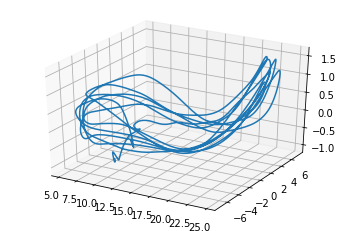

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(targets.iloc[:,0],targets.iloc[:,1],targets.iloc[:,2])
plt.show()

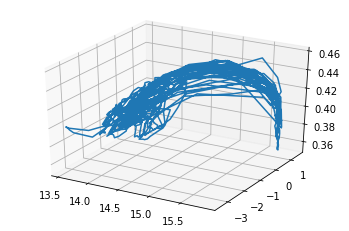

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(zeropreds[:,0],zeropreds[:,1],zeropreds[:,2])
plt.show()

In [ ]:
for idx in range(len(targets)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(targets[:idx,0],targets[:idx,1],targets[:idx,2])
    plt.savefig(f'giftestzero/zeropredstest10{idx}')
    plt.close()

In [67]:
for idx in range(len(zeropreds)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(zeropreds[:idx,0],zeropreds[:idx,1],zeropreds[:idx,2])
    plt.savefig(f'giftestzero/zeropredstest10{idx}')
    plt.close()

In [65]:
plt.close()

In [72]:
targets

,tx,ty,tz,qx,qy,qz,qw
1,4.310910,0.019995,-0.874450,0.052461,0.705153,-0.705118,-0.053065
2,4.307084,0.034576,-0.880641,0.040051,0.705947,-0.705942,-0.040992
3,4.301862,0.053290,-0.889118,-0.028785,-0.706464,0.706525,0.030049
4,4.295673,0.074945,-0.899532,-0.020226,-0.706718,0.706871,0.021762
5,4.288587,0.099754,-0.912179,-0.013528,-0.706836,0.707083,0.015316
6,4.281263,0.125798,-0.926339,-0.008569,-0.706887,0.707195,0.010593
7,4.274051,0.152010,-0.941572,-0.005037,-0.706921,0.707237,0.007288
8,4.267397,0.177027,-0.956891,-0.002955,-0.706952,0.707235,0.005395
9,4.261062,0.201974,-0.972804,-0.002207,-0.706985,0.707208,0.004784
10,4.255434,0.225576,-0.988388,-0.002887,-0.707019,0.707167,0.005526


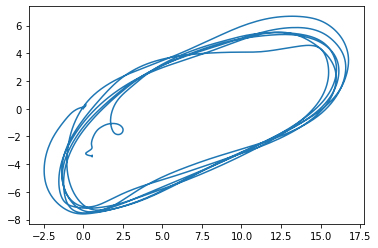

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(zerotargets[:,0],zerotargets[:,1])

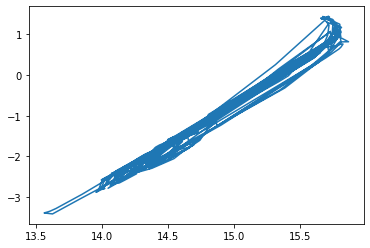

In [39]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(zeropreds[:,0],zeropreds[:,1])

In [58]:
dronenumbers=[3,5,6,7,9]
d={}
for x in dronenumbers:
    df=pd.read_csv(f'indoor/drone_{x}/groundtruth.txt', sep=' ', float_precision='high')
    df.drop(labels=['qw','#'],axis=1,inplace=True)
    ground=df.rename(columns={'qz':'qw','qy':'qz','qx':'qy','tz':'qx','ty':'tz','tx':'ty','timestamp':'tx','id':'timestamp'})
    df=pd.read_csv(f'indoor/drone_{x}/images.txt', sep=' ',float_precision='high')
    cols=df.columns
    df.rename(columns={k:v for k,v in zip(df.columns[1:3],df.columns[2:])},inplace=True)
    imdf=df.iloc[:,1:3]
    targets=filter_by_timestamp_closest(imdf,ground)
    images=np.array([[img_to_array(load_img(f'indoor/drone_{x}/'+targets.image_name.iloc[thing],color_mode='grayscale')),
            img_to_array(load_img(f'indoor/drone_{x}/'+targets.image_name.iloc[thing+1],color_mode='grayscale'))] for thing in range(len(targets)-1)])
    images=np.array(images)
    targets=targets.iloc[1:,2:-1]
    zerotargets=np.array(start_at_zeros(targets))
    d[x]=[images,zerotargets]

/home/poxlox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


FileNotFoundError: [Errno 2] File b'indoor/drone_5/groundtruth.txt' does not exist: b'indoor/drone_5/groundtruth.txt'

In [ ]:
trainimgs=np.array([d[x][0]for x in dronenumbers])
trainlabels=np.array([d[x][1]for x in dronenumbers])
trainimgs=np.vstack(trainimgs)
trainlabels=np.vstack(trainlabels)
testimgs=images
testlabels=zerotargets

In [56]:
trainimgs.shape

NameError: name 'trainimgs' is not defined

In [144]:
trainlabels.shape

(7988, 7)

In [145]:
testimgs.shape

(1121, 2, 260, 346, 1)

In [146]:
testlabels.shape

(1121, 7)

In [147]:
inputshape

(2, 260, 346, 1)

In [148]:
inputshape=images[0].shape

In [149]:
m0=Sequential()
m0.add(TimeDistributed(Conv2D(filters=64, kernel_size=(7,7), strides=(2,2),
        padding='SAME', activation='relu',input_shape=inputshape))) #1
m0.add(TimeDistributed(Conv2D(128, (5,5),strides=(2,2),padding='SAME', activation='relu'))) #2
m0.add(Dropout(0.1))
m0.add(TimeDistributed(Conv2D(256, (5,5),strides=(2,2),padding='SAME', activation='relu'))) #3
m0.add(Dropout(0.1))
m0.add(TimeDistributed(Conv2D(256, (3,3),strides=(1,1),padding='SAME', activation='relu'))) #4
m0.add(Dropout(0.1))
m0.add(TimeDistributed(Conv2D(512, (3,3),strides=(2,2),padding='SAME', activation='relu'))) #5
m0.add(Dropout(0.1))
m0.add(TimeDistributed(Conv2D(512, (3,3),strides=(1,1),padding='SAME', activation='relu'))) #6
m0.add(Dropout(0.1))
m0.add(TimeDistributed(Conv2D(512, (3,3),strides=(2,2),padding='SAME', activation='relu'))) #7
m0.add(Dropout(0.1))
m0.add(TimeDistributed(Conv2D(512, (3,3),strides=(2,2),padding='SAME', activation='relu'))) #8
m0.add(Dropout(0.1))
m0.add(TimeDistributed(Conv2D(1024, (3,3),strides=(2,2),padding='SAME'))) #9
m0.add(Dropout(0.15))
m0.add(TimeDistributed(Flatten()))
m0.add(LSTM(1000, activation='sigmoid',recurrent_activation='tanh',return_sequences=True))
m0.add(LSTM(1000, activation='sigmoid',recurrent_activation='tanh'))
m0.add(Dense(7,activation='linear'))
m0.compile(optimizer='Adagrad',lr=.0001,loss=['mse'])

In [150]:
es=EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=7)

In [ ]:
m0.fit(trainimgs,trainlabels,epochs=200,batch_size=128,callbacks=[es],validation_data=(testimgs,testlabels))

Train on 7988 samples, validate on 1121 samples
Epoch 1/200


In [46]:
(-0.326823600202155)**2

0.10681366564909806

In [47]:
(-0.326823600202155)**2 + (-0.627033435516296)**2 + (0.627109044184194)**2+ (0.326725652188376)**2

1.0

In [48]:
from scipy.spatial.transform import Rotation as R

In [61]:
R.from_quat([-0.326823600202155, -0.627033435516296, 0.627109044184194, 0.326725652188376]).as_euler('zyx')

array([-3.14146448, -0.96078912,  1.57074254])

In [55]:
r.as_euler('zyx', degrees=True)

array([-179.99265624,  -55.04916139,   89.99691853])